In [ ]:
%load_ext autoreload
%autoreload 2

from gpu import set_gpu
import numpy as np
import os
import adapt.utils.data_utils as prd
import adapt.loop as lp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import adapt.ml.dl_subclass as dl
import copy as cp
import tensorflow as tf
import pickle
from datetime import datetime

set_gpu()

In [ ]:
sub = 3
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
path += subs[sub] + '/DATA/MAT/'
all_files = os.listdir(path)
if 'skip' in all_files:
    all_files = np.delete(all_files,all_files.index('skip'))
print(subs[sub])

In [ ]:
all_files = np.delete(all_files,0)

TR62
setting ewc weights
setting lda weights
Set: 20180515_060621, Test: 20180521_090336, Accuracy: 67.36 , Cur: 92.06 , Prev: 0.00 , Val: 92.06
skip bad set: 20180521_090336, accuracy: 61.71
Set: 20180521_090336, Test: 20180524_161811, Accuracy: 81.31 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180525_084201, Accuracy: 74.75 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180531_073149, Accuracy: 76.31 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180602_105936, Accuracy: 79.96 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180604_090437, Accuracy: 74.96 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180604_214053, Accuracy: 79.33 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180605_080547, Accuracy: 79.33 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180521_090336, Test: 20180606_174322, Accuracy: 65.59 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
recal: 1 20180606_174322

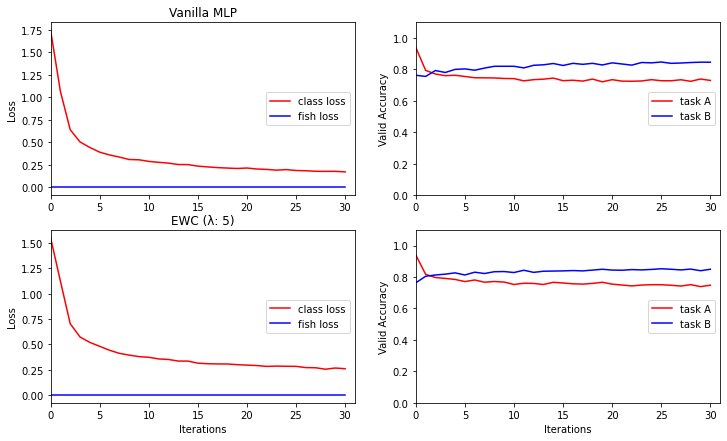

Set: 20180606_174322, Test: 20180610_081839, Accuracy: 47.27 , Cur: 86.90 , Prev: 72.59 , Val: 99.27
recal: 2 20180610_081839
Initial val acc 0: 0.9927, val acc 1: 0.4755
Final val acc 0: 0.8008, val acc 1: 0.8574
Initial val acc 0: 0.9927, val acc 1: 0.4755
loss:1.6827903, fish: 0.0, lam: 5
loss:1.2606579, fish: 2.1374317e-11, lam: 5
loss:0.6639945, fish: 6.550294e-08, lam: 5, rat: 10136866.0
loss:0.4198303, fish: 3.317793e-07, lam: 5, rat: 1265390.2
loss:0.38081014, fish: 6.8313585e-07, lam: 5, rat: 557444.25
loss:0.35130328, fish: 1.1221491e-06, lam: 5, rat: 313062.9
loss:0.330445, fish: 1.6429669e-06, lam: 5, rat: 201126.98
loss:0.3190668, fish: 2.2642964e-06, lam: 5, rat: 140912.11
loss:0.31706896, fish: 2.955689e-06, lam: 5, rat: 107274.125
loss:0.30871937, fish: 3.7254988e-06, lam: 5, rat: 82866.586
loss:0.30587775, fish: 4.5314073e-06, lam: 5, rat: 67501.71
loss:0.29351792, fish: 5.4041025e-06, lam: 5, rat: 54313.906
loss:0.29453272, fish: 6.4782384e-06, lam: 5, rat: 45464.938


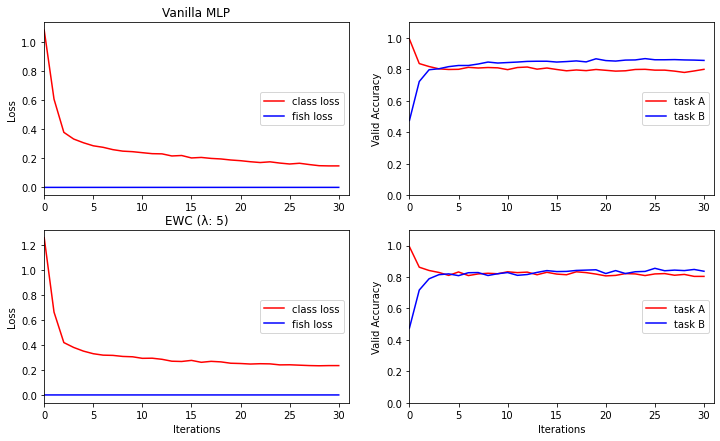

Set: 20180610_081839, Test: 20180612_085047, Accuracy: 76.68 , Cur: 84.50 , Prev: 80.50 , Val: 96.35
Set: 20180610_081839, Test: 20180614_081624, Accuracy: 77.15 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180610_081839, Test: 20180616_182930, Accuracy: 68.35 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
recal: 3 20180616_182930
Initial val acc 0: 0.9740, val acc 1: 0.6681
Final val acc 0: 0.8250, val acc 1: 0.9063
Initial val acc 0: 0.9740, val acc 1: 0.6681
loss:1.3781042, fish: 0.0, lam: 5
loss:1.4402591, fish: 5.77346e-11, lam: 5
loss:0.8158647, fish: 9.20168e-08, lam: 5, rat: 8866475.0
loss:0.59830964, fish: 3.0721242e-07, lam: 5, rat: 1947543.8
loss:0.53582394, fish: 4.8680516e-07, lam: 5, rat: 1100694.9
loss:0.50152767, fish: 6.9261387e-07, lam: 5, rat: 724108.6
loss:0.47972876, fish: 9.343531e-07, lam: 5, rat: 513434.1
loss:0.45904437, fish: 1.2352529e-06, lam: 5, rat: 371619.75
loss:0.44586244, fish: 1.5581929e-06, lam: 5, rat: 286140.72
loss:0.43605718, fish: 1.8562903e-06, lam: 5, ra

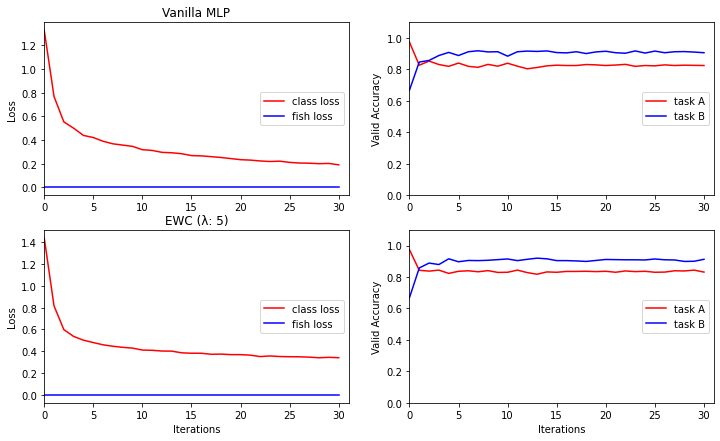

Set: 20180616_182930, Test: 20180617_184248, Accuracy: 60.33 , Cur: 85.43 , Prev: 85.83 , Val: 93.85
skip bad set: 20180617_184248, accuracy: 44.95
Set: 20180617_184248, Test: 20180619_193541, Accuracy: 79.44 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180617_184248, Test: 20180620_073139, Accuracy: 81.26 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180617_184248, Test: 20180620_073838, Accuracy: 75.90 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180617_184248, Test: 20180620_083903, Accuracy: 71.73 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180617_184248, Test: 20180621_094013, Accuracy: 79.96 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180617_184248, Test: 20180623_200107, Accuracy: 69.29 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
recal: 4 20180623_200107
Initial val acc 0: 0.9500, val acc 1: 0.7492
Final val acc 0: 0.7333, val acc 1: 0.7929
Initial val acc 0: 0.9500, val acc 1: 0.7492
loss:1.0736703, fish: 0.0, lam: 5
loss:1.043133, fish: 2.9784845e-11, lam: 5
loss:0.9380794, fish: 5.79957

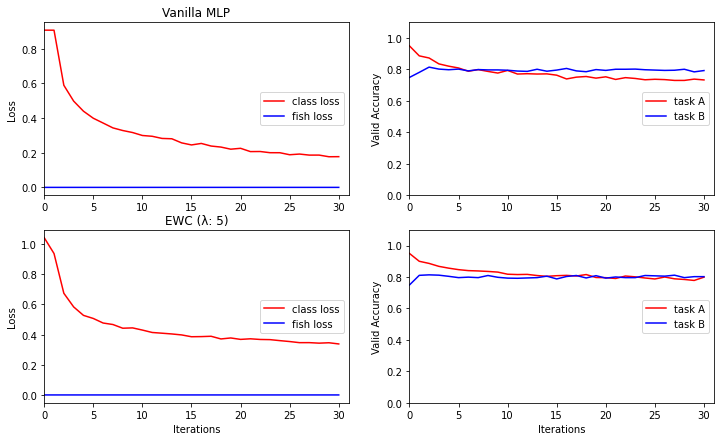

Set: 20180623_200107, Test: 20180703_072425, Accuracy: 78.14 , Cur: 74.92 , Prev: 77.40 , Val: 95.21
Set: 20180623_200107, Test: 20180711_074144, Accuracy: 74.44 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
Set: 20180623_200107, Test: 20180711_113445, Accuracy: 58.25 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
recal: 5 20180711_113445
Initial val acc 0: 0.9750, val acc 1: 0.6285
early stop
Final val acc 0: 0.6896, val acc 1: 0.7950
Initial val acc 0: 0.9750, val acc 1: 0.6285
loss:1.7504882, fish: 0.0, lam: 5
loss:1.672133, fish: 1.4213893e-10, lam: 5
loss:1.0603147, fish: 3.9882792e-07, lam: 5, rat: 2658576.8
loss:0.77443707, fish: 1.8494933e-06, lam: 5, rat: 418729.3
loss:0.67722964, fish: 3.611604e-06, lam: 5, rat: 187514.92
loss:0.62923473, fish: 5.351749e-06, lam: 5, rat: 117575.52
loss:0.59578645, fish: 7.1454274e-06, lam: 5, rat: 83380.1
loss:0.5718329, fish: 8.647076e-06, lam: 5, rat: 66130.2
loss:0.5610717, fish: 1.0152017e-05, lam: 5, rat: 55267.016
loss:0.54202294, fish: 1.1705413e-05, lam

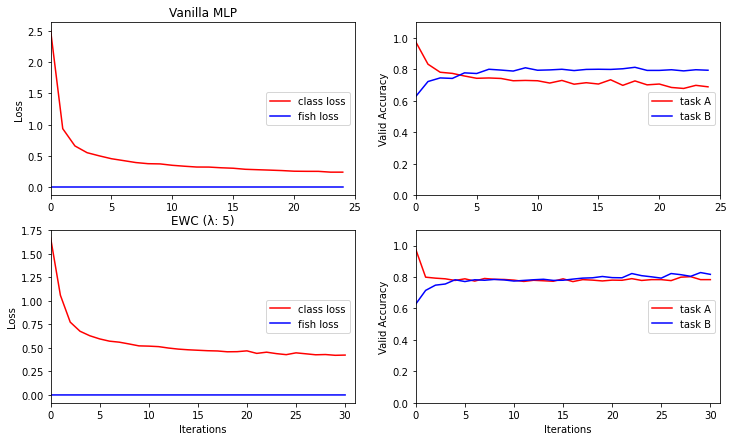

Set: 20180711_113445, Test: 20180713_102029, Accuracy: 72.57 , Cur: 78.04 , Prev: 75.21 , Val: 89.79
Set: 20180711_113445, Test: 20180717_073851, Accuracy: 66.32 , Cur: 0.00 , Prev: 0.00 , Val: 0.00
recal: 6 20180717_073851
Initial val acc 0: 0.9594, val acc 1: 0.6629
Final val acc 0: 0.5531, val acc 1: 0.8637
Initial val acc 0: 0.9594, val acc 1: 0.6629
loss:1.6248745, fish: 0.0, lam: 5
loss:1.2499406, fish: 2.0690515e-10, lam: 5
loss:0.62370974, fish: 1.0113051e-07, lam: 5, rat: 6167374.5
loss:0.4777255, fish: 7.235926e-07, lam: 5, rat: 660213.4
loss:0.42336932, fish: 1.8601985e-06, lam: 5, rat: 227593.62
loss:0.4067428, fish: 3.5163057e-06, lam: 5, rat: 115673.336
loss:0.3866841, fish: 5.883664e-06, lam: 5, rat: 65721.65
loss:0.37278718, fish: 8.2866445e-06, lam: 5, rat: 44986.504
loss:0.366857, fish: 1.0746688e-05, lam: 5, rat: 34136.75
loss:0.35742205, fish: 1.3283544e-05, lam: 5, rat: 26907.13
loss:0.34783137, fish: 1.6513788e-05, lam: 5, rat: 21063.088
loss:0.34914577, fish: 1.9

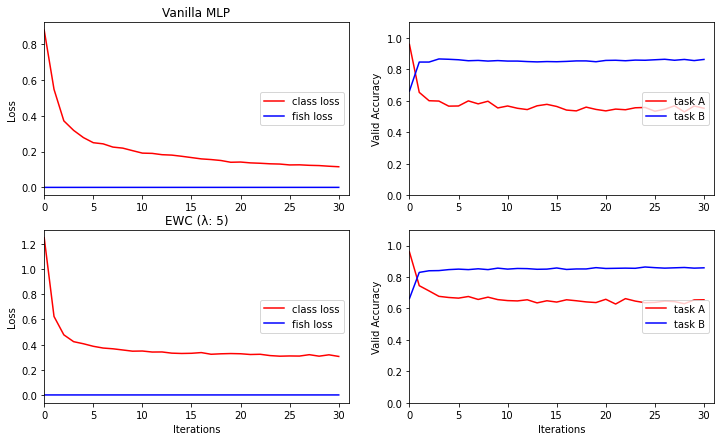

Set: 20180717_073851, Test: 20180717_112511, Accuracy: 75.48 , Cur: 82.00 , Prev: 58.02 , Val: 97.71
acewcl 6


In [27]:
# Count recalibrations
path = 'C:/Users/yteh/Documents/work/necal/home data/'
subs = os.listdir(path)
bat = 32
load_mod = True
mod_tot = ['ld','bld','bcnn','bcnnl','cnn','acnn','acewc', 'crcnnl', 'crld','cnnl','acnnl3','acnnl5','acnnl30','afcnnl','acnnlm','acewcl','acewclm']
ft = 'feat'
iter = 1

for sub in range(3,4):#5):#5):
    print(subs[sub])
    sub_path = path + subs[sub] + '/DATA/MAT/'
    all_files = os.listdir(sub_path)
    if 'skip' in all_files:
        all_files = np.delete(all_files,all_files.index('skip'))

    for it in range(0,iter):
        # first iteration, includes LDA; others exclude LDA
        if it == 0:
            # mod_all = ['bld','bcnnl','ld','cnnl','acnnl3','acnnl5','acnnl30','acewcl']
            mod_all = ['acewcl']
        else:
            mod_all = ['cnnl','acnnl3','acnnl5','acnnl30','acewcl']

        # load or initialize cnn weights
        if load_mod:
            with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
                all_acc, all_recal, all_val, all_prev, all_train, _, _, c_weights, cl_wc, scaler_0, emg_scale = pickle.load(f)
        else:
            c_weights = None
            cl_wc = None
            all_recal = np.empty((len(mod_tot),1))
            all_recal[:] = np.nan
            all_acc = np.zeros((len(all_files),len(mod_tot)))
            all_val = np.zeros((len(all_files),len(mod_tot)))
            all_prev = np.zeros((len(all_files),len(mod_tot)))
            all_train = np.zeros((len(all_files),len(mod_tot)))

        mod_i = 0
        for mod in mod_all:
            acc = np.zeros((len(all_files),5))
            acc_val = np.zeros((len(all_files),5))
            acc_prev = np.zeros((len(all_files),5))
            acc_train = np.zeros((len(all_files),5))

            if 'cnn' in mod:
                acc_i = 2
            elif 'cewc' in mod:
                acc_i = 4
            elif 'ld' in mod:
                acc_i = 0

            cnn = None
            ewc = None

            ep = 30
            recal = 0
            skip = False

            # Loop through files
            for i in range(1,len(all_files)-1):
                # Check if need to recalibrate
                if i > 1:
                    # no recalibration for baselines
                    if 'b' in mod:
                        skip = True
                    # recalibrate combined based on regular cnnl
                    # elif 'cr' in mod:
                    #     print(acc_all[it,i-1,mod_tot.index('cnnl')])
                    #     if acc_all[it,i-1,mod_tot.index('cnnl')] < 70:
                    #         skip = False
                    #     else:
                    #         skip = True
                    else:
                        if acc[i,acc_i] < 70:
                            skip = False
                        else:
                            skip = True
                    
                    if not skip:
                        train_file = all_files[i]
                        train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')
                        train_data = train_data[:,:8,:]
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)
                            
                        tr_i = np.zeros((train_params.shape[0],))
                        te_i = np.zeros((train_params.shape[0],))
                        for cls in np.unique(train_params[:,-1]):
                            dof = np.array(np.where(train_params[:,-1] == cls))
                            tr_i[dof[0,:dof.shape[1]//2]] = 1
                            te_i[dof[0,dof.shape[1]//2:]] = 1

                        train_temp = train_data[tr_i.astype(bool),...]
                        params_temp = train_params[tr_i.astype(bool),...]
                        val_data = train_data[te_i.astype(bool),...]
                        val_params = train_params[te_i.astype(bool),...]

                        train_data, train_params = train_temp, params_temp

                        _, _, _, _, _, x_tr, y_tr, emg_scale_tr, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, ft=ft, noise=False, split=False)

                        _, _, _, _, _, x_val, y_val, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale_tr, prop_b=False, ft=ft, noise=False, split=False)

                        _, _, w, c, _, _ = lp.train_models(x_train_lda=x_tr, y_train_lda=y_tr)
                        skip_test = lp.test_models(None, None, x_val, None, y_val, lda=[w,c])[0]

                        if skip_test > 70:
                            skip = False
                            recal += 1
                            print('recal: ' + str(recal) + ' ' + all_files[i])
                            acc[i,acc_i] *= -1
                        else:
                            skip = True
                            print('skip bad set: ' + all_files[i] + ', ' + f'accuracy: {skip_test:.2f}')
                        
                        del skip_test, train_data, train_params, val_data, val_params, x_tr, y_tr, x_val, y_val, emg_scale_tr, train_temp, params_temp, tr_i, te_i

                if not skip:
                    # load training file
                    train_file = all_files[i]
                    train_data, train_params = prd.load_caps_train(sub_path + train_file + '/traindata.mat')
                    train_data = train_data[:,:8,:]

                    # if first train, use two train files
                    if i == 1:
                        train_data2, train_params2 = prd.load_caps_train(sub_path + all_files[i-1] + '/traindata.mat')
                        train_data2 = train_data2[:,:8,:]
                        train_data = np.vstack((train_data,train_data2))
                        train_params = np.vstack((train_params,train_params2))
                        del train_data2, train_params2

                        train_data, train_params, th = prd.threshold(train_data, train_params)
                        val_data = train_data
                        val_params = train_params
                    else:
                        train_data, train_params, _ = prd.threshold(train_data, train_params,th)
                    
                        tr_i = np.zeros((train_params.shape[0],))
                        te_i = np.zeros((train_params.shape[0],))
                        for cls in np.unique(train_params[:,-1]):
                            dof = np.array(np.where(train_params[:,-1] == cls))
                            tr_i[dof[0,:dof.shape[1]//2]] = 1
                            te_i[dof[0,dof.shape[1]//2:]] = 1

                        train_temp = train_data[tr_i.astype(bool),...]
                        params_temp = train_params[tr_i.astype(bool),...]
                        val_data = train_data[te_i.astype(bool),...]
                        val_params = train_params[te_i.astype(bool),...]

                        train_data, train_params = train_temp, params_temp

                        del train_temp, params_temp, tr_i, te_i

                    if (i == 1 and 'a' in mod) or ('a' not in mod):
                        train_dof = np.unique(train_params[:,-1])
                        key = np.empty(train_dof.shape)
                        for key_i in range(len(train_dof)):
                            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])
                    
                    train_data, train_params = lp.check_labels(train_data,train_params,train_dof,key)
                    val_data, val_params = lp.check_labels(val_data,val_params,train_dof,key)

                    # if combining, save current training data
                    if 'cr' in mod:
                        # combine old and new training data
                        if i > 1:
                            train_data = np.vstack((train_data_0,train_data))
                            train_params = np.vstack((train_params_0,train_params))

                        train_data_0 = cp.deepcopy(train_data)
                        train_params_0 = cp.deepcopy(train_params)
                    
                    if i == 1:
                        n_dof = int(np.max(key))

                    if ('a' in mod and i > 1) or ('cr' in mod and i > 1):
                        _, traincnn, y_train, _, x_train_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale, scaler=scaler, num_classes=n_dof, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                    else:
                        _, traincnn, y_train, _, x_train_cnn, x_train_lda, y_train_lda, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=bat, ft=ft, noise=True, split=False)
                        if (i == 1) and (c_weights is not None):
                            scaler = cp.deepcopy(scaler_0)

                    # if 'ewc' in mod:
                    _, _, y_clean, _, x_clean_cnn, x_clean_lda, y_clean_lda, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)
                    _, _, y_val, _, x_val_cnn, x_val_lda, y_val_lda, _, _, _, _, _ = prd.prep_train_caps(val_data, val_params, emg_scale=emg_scale,scaler=scaler, prop_b=False, batch_size=bat, ft=ft, num_classes=n_dof, noise=False, split=False)

                    if 'cnn' in mod:
                        n_dof = int(np.max(key))
                        if 'cnnl' in mod:
                            if i == 1:
                                if c_weights is None:
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnnlda=True)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    cl_wc = cp.deepcopy([w_c.astype('float32'),c_c.astype('float32')])
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    print('setting CNN weights')
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    if cl_wc is None:
                                        _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=cnn.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                                        cl_wc = cp.deepcopy([w_c.astype('float32'),c_c.astype('float32')])
                                    else:
                                        w_c = cp.deepcopy(cl_wc[0])
                                        c_c = cp.deepcopy(cl_wc[1])
                                        print('setting lda weights')
                            else:
                                if mod =='acnnlm': # update CNN encoder using lda for loss
                                    ep = 5
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnn=[cnn,w_c,c_c])
                                elif 'acnnl' in mod: # update whole CNN and lda weights
                                    ep = int(mod[-1])
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnn=cnn, cnnlda=True, lr=0.00001)
                                elif mod == 'cnnl' or mod == 'crcnnl': # recalibrate cnnlda
                                    _, cnn, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnnlda=True)
                                elif mod == 'afcnnl': # update lda only 
                                    _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=cnn.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                                
                                acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, cnn=cnn, clda=[w_c,c_c])
                            
                            acc_val[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, cnn=cnn, clda=[w_c,c_c])
                            acc_train[i,:] = lp.test_models(x_clean_cnn, None, None, y_clean, None, cnn=cnn, clda=[w_c,c_c])
                        else:       
                            if i == 1:
                                if c_weights is None:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                                    c_weights = cp.deepcopy(cnn.get_weights())
                                    scaler_0 = cp.deepcopy(scaler)
                                else:
                                    cnn = dl.CNN(n_class=n_dof)
                                    cnn(x_train_cnn[:1,...])
                                    cnn.set_weights(c_weights)
                                    print('setting weights')
                            else:
                                if 'a' in mod:
                                    ep = 5
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep, cnn=cnn)
                                else:
                                    _, cnn, _, _, _, _ = lp.train_models(traincnn, n_dof=n_dof, ep=ep)
                                acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, cnn=cnn)
                            acc_val[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, cnn=cnn)
                            acc_train[i,:] = lp.test_models(x_clean_cnn, None, None, y_clean, None, cnn=cnn)
                    elif 'ewc' in mod:
                        if i == 1:
                            lam = 0
                            ewc = dl.EWC(mod='CNN', n_class=n_dof)
                            ewc(x_train_cnn[:1,...])
                            if c_weights is not None:
                                ewc.set_weights(c_weights)
                                print('setting ewc weights')
                                if cl_wc is None:
                                    _, _, w_c, c_c, _, _ = lp.train_models(x_train_lda=ewc.enc(x_train_cnn).numpy(), y_train_lda=np.argmax(y_train,axis=1)[...,np.newaxis])
                                    cl_wc = cp.deepcopy([w_c,c_c])
                                else:
                                    w_c = cp.deepcopy(cl_wc[0])
                                    c_c = cp.deepcopy(cl_wc[1])
                                    print('setting lda weights')
                            else:
                                _, ewc, _, _, w_c, c_c = lp.train_models(traincnn=x_train_cnn,y_train=y_train, n_dof=n_dof, ep=ep, cnnlda=True)
                                # w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train,[x_val_cnn], [y_val], lams=[lam],bat=bat)
                                c_weights = cp.deepcopy(ewc.get_weights())
                                scaler_0 = cp.deepcopy(scaler)
                                cl_wc = cp.deepcopy([w_c,c_c])                         
                        else:
                            lam = 5
                            if mod == 'acewclm':
                                _, _ = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [x_val_cnn], [y_val], lams=[lam], bat=bat, clda=[w_c,c_c])
                            elif mod == 'acewcl':
                                w_c, c_c = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, [prev_x, x_val_cnn],[prev_y, y_val], lams=[0,lam], bat=bat)
                            else:
                                _, _ = lp.train_task(ewc, ep, 1, x_train_cnn, y_train, lams=[lam], bat=bat)
                            acc_prev[i,:] = lp.test_models(prev_x, None, None, prev_y, None, ewc_cnn=ewc, clda=[w_c,c_c])
                        acc_val[i,:] = lp.test_models(x_val_cnn, None, None, y_val, None, ewc_cnn=ewc, clda=[w_c,c_c])
                        acc_train[i,:] = lp.test_models(x_clean_cnn, None, None, y_clean, None, ewc_cnn=ewc, clda=[w_c,c_c])
                        
                        ewc.compute_fisher(x_clean_cnn, y_clean, num_samples=200, plot_diffs=False) 
                        ewc.star()
                    elif 'ld' in mod:
                        _, _, w, c, _, _ = lp.train_models(x_train_lda=x_lda, y_train_lda=y_lda)
                        acc_val[i,:] = lp.test_models(None, None, x_val, None, y_val_lda, lda=[w,c])
                        acc_train[i,:] = lp.test_models(None, None, x_clean_lda, None, y_clean_lda, lda=[w,c])
                        if i > 1:
                            acc_prev[i,:] = lp.test_models(None, None, prev_x_lda, None, prev_y_lda, lda=[w,c])
                        del x_lda, y_lda
                    
                    prev_x = cp.deepcopy(x_val_cnn)
                    prev_y = cp.deepcopy(y_val)
                    prev_x_lda = cp.deepcopy(x_val_lda)
                    prev_y_lda = cp.deepcopy(y_val_lda)
                    
                    del x_train_cnn, y_train, traincnn, x_val_cnn, y_val, x_val_lda, y_val_lda, train_params, train_data, val_params, val_data, x_clean_cnn, y_clean, x_clean_lda, y_clean_lda
                
                # load data
                test_file = all_files[i+1]
                test_data, test_params = prd.load_caps_train(sub_path + test_file + '/traindata.mat')
                test_data = test_data[:,:8,:]
                
                # check class labels
                test_data, test_params, _ = prd.threshold(test_data, test_params, th)
                test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

                # test 
                y_test, _, x_test_cnn, x_test_lda, y_test_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft, split=False)

                # test 
                if 'cnn' in mod:
                    if 'cnnl' in mod:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, cnn=cnn, clda=[w_c,c_c])
                    else:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, cnn)
                elif 'cewc' in mod:
                    if 'cewcl' in mod:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, ewc_cnn=ewc, clda=[w_c,c_c])
                    else:
                        acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, ewc_cnn=ewc)
                elif 'ld' in mod:
                    acc[i+1,:] = lp.test_models(x_test_cnn, None, x_test_lda, y_test, y_test_lda, lda=[w,c])

                print ('Set: ' + train_file + ', Test: ' + test_file + ',', f'Accuracy: {acc[i+1,acc_i]:.2f}', f', Cur: {acc_cur[i,acc_i]:.2f}', f', Prev: {acc_prev[i,acc_i]:.2f}', f', Val: {acc_val[i,acc_i]:.2f}')
                del y_test, x_test_cnn, x_test_lda, y_test_lda, test_data, test_params

            all_acc[:,mod_tot.index(mod)] = acc[:,acc_i]
            all_recal[mod_tot.index(mod)] = recal
            all_val[:,mod_tot.index(mod)] = acc_val[:,acc_i]
            all_prev[:,mod_tot.index(mod)] = acc_prev[:,acc_i]
            all_train[:,mod_tot.index(mod)] = acc_train[:,acc_i]
            print(mod + ' ' + str(recal))
            mod_i += 1

            if 'cr' in mod:
                del train_data_0, train_params_0

        with open(subs[sub] + '_' + str(it) + '_r_accs.p','wb') as f:
            pickle.dump([all_acc, all_recal, all_val, all_prev, all_train, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale],f)

In [ ]:
cv_iter = 1
fig,ax = plt.subplots(1,5,figsize=(30,4))
for sub in range(2,3):#,5):
    with open(subs[sub] + '_0_r_accs.p','rb') as f:
        # acc_all, recal_all = pickle.load(f)
        acc_all, recal_all, cur_all, prev_all, val_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

    # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
    colors =  cm.get_cmap('tab20c')
    c = np.empty((20,4))
    for i in range(20):
        c[i,:] = colors(i*1/20)


    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
    nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
    nn_c[0,-1] = 1
    all_m = ['ko-','o-','o-','s-','s-','v-','v-']
    pt_m = ['ko-','o-','o-','o-','s','s','s','s','D']
    nn_c = np.vstack((np.array([0,0,0,1]), c[0,:],c[1,:],c[2,:],c[3,:],c[4,:],c[5,:],c[6,:],c[0,:],c[8,:],c[0,:]))
    # nn_c[0,-1] = 1

    labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
    labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
    # labels = mod_tot

    ax_ind = sub
    it = 0
    for v in [1,2]: 
        i = mod_tot.index(mod_all[v])
        acc_temp = acc_all[1:-1,i]
        if not np.isnan(acc_temp).all():
            x = np.arange(len(acc_temp))
            recal_i = (acc_temp < 0)
            ax[ax_ind].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
            ax[ax_ind].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v],color=nn_c[it,:])
            ax[ax_ind].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
            it+=1

    for i in range(5):
        ax[i].axhline(70, ls='--', color='grey')
        
        ax[i].set_ylim([0,100])
        ax[i].set_title('TR' + str(i+1))
    ax[0].legend()
    ax[2].set_xlabel('Calibration Set')
    ax[0].set_ylabel('Accuracy (%)')
    plt.rc('font', size=15) 

In [ ]:
cv_iter = 1
for sub in range(2,3):#,5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, val_all,mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        pt_m = ['ko','*','*','o','s','s','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [1,0,0,1,2,2,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[it]+': ' + str(int(recal_all[i,0])),color=nn_c[it,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[it,:])
                it+=1

    for i in range(4):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
from matplotlib.ticker import MaxNLocator
cv_iter = 1
for sub in range(0,5):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    for it in range(0,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, cur_all, prev_all, mod_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        # mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)


        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','*','o','s','D','s','s','D']
        nn_c = np.vstack((np.array([0,0,0,1]),np.array([0,0,0,1]), c[0,:],c[1,:],c[4,:],c[5,:],c[6,:],c[8,:],c[6,:],c[0,:],c[8,:],c[0,:]))

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']
        labels = ['r-lda','lda','cnn','r-cnn','a-cnn-5','a-cnn-3','a-cnn-30','ewc-cnn']
        labels = ['r-lda','lda','cnn','r-cnn','f-cnn-5','f-cnn-3','f-cnn-30','ewc-cnn']
        # labels = mod_tot

        ax_ind = [0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3]
        it = 0
        for v in [0, 3, 5, 4, 6, 7]: #range(len(mod_all)):
            i = mod_tot.index(mod_all[v])
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[it]].plot(np.abs(acc_temp),'-',color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[it],label=labels[v]+': ' + str(int(recal_all[i,0])),color=nn_c[v,:])
                ax[ax_ind[it]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[v,:])
                ax[ax_ind[it]].xaxis.set_major_locator(MaxNLocator(integer=True))
                it+=1

    for i in range(2):
        ax[i].axhline(70, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
        

    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
cv_iter = 5
for sub in [0,2]:#range(1):#5):
    fig,ax = plt.subplots(1,4,figsize=(20,4))
    for it in range(1,cv_iter):
        with open(subs[sub] + '_' + str(it) + '_r_accs.p','rb') as f:
            # acc_all, recal_all = pickle.load(f)
            acc_all, recal_all, mod_tot, c_weights, cl_wc, scaler_0, emg_scale= pickle.load(f)

        mod_all = ['ld','bld','bcnnl','cnnl','acnnl','acnnl3','acnnl30','acewcl']
        colors =  cm.get_cmap('tab20c')
        c = np.empty((20,4))
        for i in range(20):
            c[i,:] = colors(i*1/20)

        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[9,:],c[1,:],c[10,:],c[2,:]))
        nn_c = np.vstack((np.zeros((1,4)),c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:],c[8,:],c[0,:]))
        nn_c[0,-1] = 1
        all_m = ['ko-','o-','o-','s-','s-','v-','v-']
        pt_m = ['ko','o','o','s','s','v','v','D','D','D']

        labels = ['lda','mlp','cnn','a-mlp','a-cnn','ewc-mlp','ewc-cnn','c-mlp','c-cnn','c-ld']

        # d0 = datetime(int(all_files[0][:4]),int(all_files[0][4:6]),int(all_files[0][6:8]),int(all_files[0][9:11]),int(all_files[0][11:13]),int(all_files[0][13:]))
        # delta = np.empty((len(acc_all)-1,1))
        # for i in range(1,len(acc_all)-1):
        #     d1 = datetime(int(all_files[i][:4]),int(all_files[i][4:6]),int(all_files[i][6:8]),int(all_files[i][9:11]),int(all_files[i][11:13]),int(all_files[i][13:]))
        #     delta[i] = (d1 - d0).total_seconds()
            
        ax_ind = [0,0,0,1,1,2,2,3,3,3]
        for i in [0,2,4,6,8,9]:#range(3):#acc_all.shape[-1]):
            acc_temp = acc_all[1:-1,i]
            if not np.isnan(acc_temp).all():
                x = np.arange(len(acc_temp))
                recal_i = (acc_temp < 0)
                ax[ax_ind[i]].plot(np.abs(acc_temp),'-',color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[~recal_i],np.abs(acc_temp[~recal_i]),pt_m[i],label=labels[i]+': ' + str(int(recal_all[i,0])),color=nn_c[i,:])
                ax[ax_ind[i]].plot(x[recal_i],np.abs(acc_temp[recal_i]),'x',ms=10,color=nn_c[i,:])

    for i in range(4):
        ax[i].axhline(65, ls='--', color='grey')
        ax[i].legend()
        ax[i].set_ylim([0,100])
    ax[0].set_ylabel('Accuracy (%)')

In [ ]:
train_file = all_files[0]
train_file2 = all_files[1]
ft= 'feat'

train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
train_data = train_data[:,:8,:]

train_dof = np.unique(train_params[:,2])
key = np.empty(train_dof.shape)
for i in range(len(train_dof)):
    key[i] = train_params[np.argmax(train_params[:,2] == train_dof[i]),0]

In [ ]:
train_data2, train_params2 = prd.load_caps_train(path + train_file2 + '/traindata.mat')
train_data2 = train_data2[:,:8,:]
train_data = np.vstack((train_data,train_data2))
train_params = np.vstack((train_params,train_params2))

In [ ]:
# Prep initial training data
ep = 30
n_dof = len(train_dof)

# train_data, train_params = prd.threshold(train_data, train_params)
trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32,ft=ft, noise=True, split=False)
y_test_0, x_test_mlp_0, x_test_cnn_0, x_lda_0, y_lda_0 = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)


In [ ]:
# Initial training
mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=3)
mlp_0 = mlp.get_weights()
cnn_0 = cnn.get_weights()
w_0 = cp.deepcopy(w)
c_0 = cp.deepcopy(c)

In [ ]:
# LDA recalibration threshold
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)-1):
    # load data
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]
    # train_data, train_params = prd.threshold(train_data, train_params)

    train_dof = np.unique(train_params[:,2])
    key = np.empty(train_dof.shape)
    for ki in range(len(train_dof)):
        key[ki] = train_params[np.argmax(train_params[:,2] == train_dof[ki]),0]

    _, _, _, _, _, x_train_lda_0, y_train_lda_0, _, _, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b=False, batch_size=32, ft=ft, noise=False, split=False, emg_scale=np.ones((train_data.shape[1],1)))

    _, _, w, c = lp.train_models(x_train_lda=x_train_lda_0, y_train_lda=y_train_lda_0)

    # load data
    test_file = all_files[i+1]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, lda = [w, c])
    print ('Set: ' + test_file, f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
# Train and test on current dataset
acc = np.empty((len(all_files),5))
# old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = [], [], [], [], []

for i in range(0,len(all_files)):
    train_file = all_files[i]
    train_data, train_params = prd.load_caps_train(path + train_file + '/traindata.mat')
    train_data = train_data[:,:8,:]

    orig_train_dof = np.unique(train_params[:,2])
    train_data, train_params = prd.threshold(train_data, train_params)
    train_dof = np.unique(train_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        n_dof = len(train_dof)
        key = np.empty(train_dof.shape)
        for key_i in range(len(train_dof)):
            key[key_i] = cp.deepcopy(train_params[np.argmax(train_params[:,2] == train_dof[key_i]),0])

        trainmlp_0, traincnn_0, y_train_0, x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, emg_scale, scaler, _, _, _ = prd.prep_train_caps(train_data, train_params, prop_b = False, batch_size=32, ft=ft, noise=False, split=True)

        if i > 0:
            x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0 = np.vstack((old_train_mlp, x_train_mlp_0)), np.vstack((old_train_cnn, x_train_cnn_0)), np.vstack((old_x_train_lda, x_train_lda_0)), np.vstack((old_y_train_lda, y_train_lda_0)), np.vstack((old_y_train, y_train_0))

            trainmlp_0 = tf.data.Dataset.from_tensor_slices((x_train_mlp_0, y_train_0, y_train_0)).shuffle(x_train_mlp_0.shape[0],reshuffle_each_iteration=True).batch(32)
            traincnn_0 = tf.data.Dataset.from_tensor_slices((x_train_cnn_0, y_train_0, y_train_0)).shuffle(x_train_cnn_0.shape[0],reshuffle_each_iteration=True).batch(32)

        mlp, cnn, w, c = lp.train_models(traincnn_0, trainmlp_0, x_train_lda_0, y_train_lda_0, n_dof, ep=30)

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(train_data, train_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=True)
        acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
        print ('Set: ' + train_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')
        old_train_mlp, old_train_cnn, old_x_train_lda, old_y_train_lda, old_y_train = x_train_mlp_0, x_train_cnn_0, x_train_lda_0, y_train_lda_0, y_train_0
    else:
        print('Skipping ' + train_file)

In [ ]:
# Train on initial, test without recalibration or adaptation
acc = np.empty((len(all_files),5))

for i in range(0,len(all_files)):
    # load data
    test_file = all_files[i]
    test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
    test_data = test_data[:,:8,:]

    # test_data, test_params = prd.threshold(test_data, test_params)
    
    # check class labels
    test_data, test_params = lp.check_labels(test_data,test_params,train_dof,key)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=len(train_dof),ft=ft, split=False)
    acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c])
    print ('Set: ' + test_file, f'CNN Accuracy: {acc[i,2]:.2f},', f'MLP Accuracy: {acc[i,1]:.2f},', f'LDA Accuracy: {acc[i,0]:.2f}')

In [ ]:
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0,y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0,y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w, c], ewc, ewc_cnn)
print(ewc_acc[0,:])

for i in range(1,len(all_files)-1,1):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    # check class labels
    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):
        # n_dof = len(train_dof)
        
        # training data
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        # validation data for fisher
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
        # test data
        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft,split=True)
        # test data for recalibration
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft,split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, n_dof=n_dof, ep=5, mlp=mlp, cnn=cnn)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, n_dof=n_dof, ep=30)

        # test
        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ',', f'EWC CNN Accuracy: {ewc_acc[i,4]:.2f},', f'EWC Accuracy: {ewc_acc[i,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i,0]:.2f}')
    else:
        print('Skipping ' + ewc_file)

In [ ]:
# Test all controllers with ewc
ep = 30
# Remove extra file if odd number of files
if len(all_files)%2 == 0:
    all_files = np.delete(all_files,-1)
ewc_acc = np.empty((len(all_files),5))
ewc_acc[:] = np.nan
rec_acc = np.empty((len(all_files),5))
rec_acc[:] = np.nan

n_dof = len(train_dof)

cnn.set_weights(cnn_0)
mlp.set_weights(mlp_0)

ewc_cnn = dl.EWC(mod='CNN')
ewc_cnn(x_train_cnn_0[:1,...])
loss, fish_loss = lp.train_task(ewc_cnn, ep, 1, x_train_cnn_0, y_train_0, [x_test_cnn_0],[y_test_0], lams=[0])
x_test_ewc_cnn_0 = cp.deepcopy(x_test_cnn_0)
y_test_ewc_0 = cp.deepcopy(y_test_0)
x_val_ewc_cnn = cp.deepcopy(x_test_cnn_0)
y_val_ewc = cp.deepcopy(y_test_0)

ewc = dl.EWC()
ewc(x_train_mlp_0[:1,...])
loss, fish_loss = lp.train_task(ewc, ep, 1, x_train_mlp_0, y_train_0, [x_test_mlp_0],[y_test_0], lams=[0])
x_test_ewc_0 = cp.deepcopy(x_test_mlp_0)
x_val_ewc = cp.deepcopy(x_test_mlp_0)

ewc_acc[0,:] = lp.test_models(x_test_cnn_0, x_test_mlp_0, x_lda_0, y_test_0, y_lda_0, cnn, mlp, [w_0, c_0], ewc, ewc_cnn)

for i in range(7,len(all_files)-1,2):
    # load recalibration data
    ewc_file = all_files[i]
    ewc_data, ewc_params = prd.load_caps_train(path + ewc_file + '/traindata.mat')
    ewc_data = ewc_data[:,:8,:]

    ewc_cnn.compute_fisher(x_val_ewc_cnn, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc_cnn.star()

    ewc.compute_fisher(x_val_ewc, y_val_ewc, num_samples=200, plot_diffs=False) # use validation set for Fisher computation
    ewc.star()

    orig_train_dof = np.unique(ewc_params[:,2])
    ewc_data, ewc_params = prd.threshold(ewc_data, ewc_params)
    train_dof = np.unique(ewc_params[:,2])

    if len(orig_train_dof) == len(train_dof):

        # check class labels
        ewc_data, ewc_params = lp.check_labels(ewc_data, ewc_params, train_dof, key)
        
        ewcmlp, ewccnn, y_train_ewc, x_train_ewc, x_train_ewc_cnn, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=True, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)
        _, _, y_val_ewc, x_val_ewc, x_val_ewc_cnn, _, _, _, _, _, _, _= prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, num_classes=n_dof, batch_size=64, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft, split=True)

        y_test_ewc, x_test_ewc, x_test_ewc_cnn, x_lda, y_lda = prd.prep_test_caps(ewc_data, ewc_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)

        loss, fish_loss = lp.train_task(ewc_cnn, 30, 1, x_train_ewc_cnn, y_train_ewc, [x_test_ewc_cnn_0, x_test_ewc_cnn], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        loss, fish_loss = lp.train_task(ewc, 30, 1, x_train_ewc, y_train_ewc, [x_test_ewc_0, x_test_ewc], [y_test_ewc_0, y_test_ewc], lams=[15])#,15,50])
        mlp, cnn, _, _ = lp.train_models(ewccnn, ewcmlp, x_train_lda, y_train_lda, n_dof, 30, mlp, cnn)
        
        # training data for recalibration
        rmlp, rcnn, y_train_r, x_train_r, x_train_r_cnn, x_train_r_lda, y_train_r_lda, r_emg_scale, r_scaler, _, _, _ = prd.prep_train_caps(ewc_data, ewc_params, prop_b = False, batch_size=32, noise=True, ft=ft, split=True)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(ewc_data, ewc_params, r_scaler, r_emg_scale, ft=ft, split=True)

        mlp_r, cnn_r, w, c = lp.train_models(rcnn, rmlp, x_train_r_lda, y_train_r_lda, ep=30)

        # load test data
        test_file = all_files[i+1]
        test_data, test_params = prd.load_caps_train(path + test_file + '/traindata.mat')
        test_data = test_data[:,:8,:]
        
        # check class labels
        test_data, test_params = prd.threshold(test_data, test_params)
        test_data, test_params = lp.check_labels(test_data, test_params, train_dof, key)

        ewc_acc[i,:] = lp.test_models(x_test_ewc_cnn, x_test_ewc, x_lda, y_test_ewc, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        # test 
        y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(test_data, test_params, scaler, emg_scale, num_classes=n_dof, ft=ft)
        y_test_r, x_test_r, x_test_r_cnn, x_r_lda, y_r_lda = prd.prep_test_caps(test_data, test_params, r_scaler, r_emg_scale, num_classes=n_dof,ft=ft)
        ewc_acc[i+1,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, ewc=ewc, ewc_cnn=ewc_cnn)
        rec_acc[i+1,:] = lp.test_models(x_test_r_cnn, x_test_r, x_r_lda, y_test_r, y_r_lda, cnn_r, mlp_r, lda=[w,c])

        x_test_ewc_cnn_0 = cp.deepcopy(x_test_ewc_cnn)
        x_test_ewc_0 = cp.deepcopy(x_test_ewc)
        y_test_ewc_0 = cp.deepcopy(y_test_ewc)

        print ('EWC: ' + ewc_file + ', Test: ' + test_file + ',', f'EWC CNN Accuracy: {ewc_acc[i+1,4]:.2f},', f'EWC Accuracy: {ewc_acc[i+1,3]:.2f},', f'a-CNN Accuracy: {ewc_acc[i+1,2]:.2f},', f'a-MLP Accuracy: {ewc_acc[i+1,1]:.2f},',  f'r-CNN Accuracy: {rec_acc[i+1,2]:.2f},', f'r-MLP Accuracy: {rec_acc[i+1,1]:.2f},', f'r-LDA Accuracy: {rec_acc[i+1,0]:.2f}')
    else:
        print('Skipping: ' + ewc_file)

In [ ]:
ewc_acc[0,...] = np.nan
rec_acc[0,...] = np.nan
rlda_acc = np.empty((len(all_files),15))
rlda_acc[:] = np.nan
lda_acc = np.empty((len(all_files),15))
lda_acc[:] = np.nan
acc_all = np.hstack((acc[:,...],ewc_acc,rec_acc))
for i in range(acc.shape[1]):
    rlda_acc[:,i] = acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+5] = ewc_acc[:,i] - ewc_acc[:,0]
    rlda_acc[:,i+10] = rec_acc[:,i] - ewc_acc[:,0]

    lda_acc[:,i] = acc[:,i] - acc[:,0]
    lda_acc[:,i+5] = ewc_acc[:,i] - acc[:,0]
    lda_acc[:,i+10] = rec_acc[:,i] - acc[:,0]

In [ ]:
lda_i = [0, 5]
cnn_i = [2, 12, 7, 9]
mlp_i = [1, 11, 6, 8]
nn_i = np.vstack((mlp_i,cnn_i))

colors =  cm.get_cmap('tab20c')
c = np.empty((20,4))
for i in range(20):
    c[i,:] = colors(i*1/20)

mlp_c = np.vstack((c[8,:],c[9,:],c[10,:],c[11,:]))
cnn_c = np.vstack((c[0,:],c[1,:],c[2,:],c[3,:]))
nn_c = np.stack((mlp_c,cnn_c))
lda_c = ['ko-','ko--']
nn_m = ['o-','s-','v-','x-']

In [ ]:
mask = ~np.isnan(rlda_acc)

for mod in range(nn_i.shape[0]):
    i_ = nn_i[mod,...]
    fig,ax = plt.subplots(1,3,figsize=(16,4))

    # for i in range(len(lda_i)):
        # ax[0].plot(acc_all[mask[:,lda_i[i]],lda_i[i]][1::2], lda_c[i])
    for i in range(len(i_)):
        ax[0].plot(acc_all[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[1].plot(rlda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])
        ax[2].plot(lda_acc[mask[:,i_[i]],i_[i]][1::2], nn_m[i], color=nn_c[mod,i,:])

    if mod == 0:
        ax[0].legend(['LDA', 'r-LDA', 'MLP', 'r-MLP', 'a-MLP', 'ewc-MLP'])
        ax[1].legend(['MLP vs. r-LDA', 'r-MLP vs. r-LDA', 'a-MLP vs. r-LDA', 'ewc-MLP vs. r-LDA'])
        ax[2].legend(['MLP vs. LDA', 'r-MLP vs. LDA', 'a-MLP vs. LDA', 'ewc-MLP vs. LDA'])
    else:
        ax[0].legend(['LDA', 'r-LDA', 'CNN', 'r-CNN', 'a-CNN', 'ewc-CNN'])
        ax[1].legend(['CNN vs. r-LDA', 'r-CNN vs. r-LDA', 'a-CNN vs. r-LDA', 'ewc-CNN vs. r-LDA'])
        ax[2].legend(['CNN vs. LDA', 'r-CNN vs. LDA', 'a-CNN vs. LDA', 'ewc-CNN vs. LDA'])

    ax[0].set_ylim([0,100])
    ax[1].axhline(0, ls = '--',color='black')
    ax[2].axhline(0, color='black')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o', label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-')

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls)

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-')

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
x = range(0,acc.shape[0]-2,1)
x_skip = range(0,acc.shape[0]-2,2)

for i in range(3):
    ax[0].plot(x_skip,acc[2::2,i],'o',color=col[i,:], label='_nolegend_')
    ax[0].plot(x,acc[2:,i],'-',color=col[i,:])

    if i == 0:
        ls = 's--'
    else:
        ls = 's-'
    ax[1].plot(x_skip,recal_acc[mask,i], ls,color=col[i,:])

    if i > 0:
        ax[2].plot(x_skip,adapt_acc[mask,i], 'v-',color=col[i,:])

    ax[i].set_ylim([0,100])

ax[0].legend(['LDA','MLP','CNN'])
ax[1].legend(['r-LDA','r-MLP','r-CNN'])
ax[2].legend(['a-MLP','a-CNN'])  

In [ ]:
# Test all controllers with adaptation
ep = 30
# Remove extra file if odd number of files
# if len(all_files)%2 == 0:
#     all_files = np.delete(all_files,-1)
align_acc = np.empty((len(all_files),5))
align_acc[:] = np.nan
n_dof = len(train_dof)

for i in range(2,len(all_files)-1):
    # load recalibration data
    align_file = all_files[i]
    align_data, align_params = prd.load_caps_train(path + align_file + '/traindata.mat')
    align_data = align_data[:,:8,:]

    # check class labels
    align_data, align_params = prd.threshold(align_data, align_params)
    align_data, align_params = lp.check_labels(align_data, align_params, train_dof, key)
    
    alignmlp, aligncnn, _, _, _, x_train_lda, y_train_lda, _, _, _, _, _ = prd.prep_train_caps(align_data, align_params, prop_b = False, num_classes=n_dof, batch_size=32, noise=False, scaler=scaler, emg_scale=emg_scale,ft=ft,split=True)
    mlp, cnn, mlp_ali, cnn_ali, w, c = lp.train_models(aligncnn, alignmlp, x_train_lda, y_train_lda, n_dof, ep, mlp, cnn, align=True)

    # test 
    y_test, x_test_mlp, x_test_cnn, x_lda, y_lda = prd.prep_test_caps(align_data, align_params, scaler, emg_scale, num_classes=n_dof,ft=ft, split=True)
    align_acc[i,:] = lp.test_models(x_test_cnn, x_test_mlp, x_lda, y_test, y_lda, cnn, mlp, [w, c], cnn_align=cnn_ali, mlp_align=mlp_ali)

    print ('Align: ' + align_file + ',', f'CNN Accuracy: {align_acc[i,2]:.2f},', f'MLP Accuracy: {align_acc[i,1]:.2f},', f'LDA Accuracy: {align_acc[i,0]:.2f}')